# Leios simulation analysis at tag `leios-2025w29`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: linear (no transactions)

In [2]:
label <- "Rust simulator, mini-mainnet, linear, no txs"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
if (file.exists("results/notxs/lifecycle.Rdata")) {
    load(file="results/notxs/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/notxs/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(lifecycle, sampleSize, file="results/notxs/lifecycle.R")
}
lifecycle[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
lifecycle %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator          Stage length     Max EB size  Kind                Item     
 Rust:2360   5 slot/stage :1180   5.0 MB/EB:520   EB: 590   20-node-220 :  20  
             8 slot/stage :1180   2.0 MB/EB:448   RB: 590   131-node-573:  16  
             15 slot/stage:   0   1.0 MB/EB:416   TX:1180   177-node-149:  16  
                                  0.5 MB/EB:520             219-node-475:  16  
                                  0.2 MB/EB:456             26-node-95  :  16  
                                                            54-node-525 :  16  
                                                            (Other)     :2260  
    Size [B]         References      Created [s]     To IB [s]     
 Min.   :  90112   Min.   :0.0000   Min.   :  20.0   Mode:logical  
 1st Qu.:  90880   1st Qu.:0.0000   1st Qu.: 296.1   NA's:2360     
 Median : 145568   Median :1.0000   Median : 576.0                 
 Mean   : 948592   Mean   :0.6309   Mean   : 592.4                 
 3rd Qu.:1000000   3

In [4]:
simFinish <- 1200

#### Size of persisted data

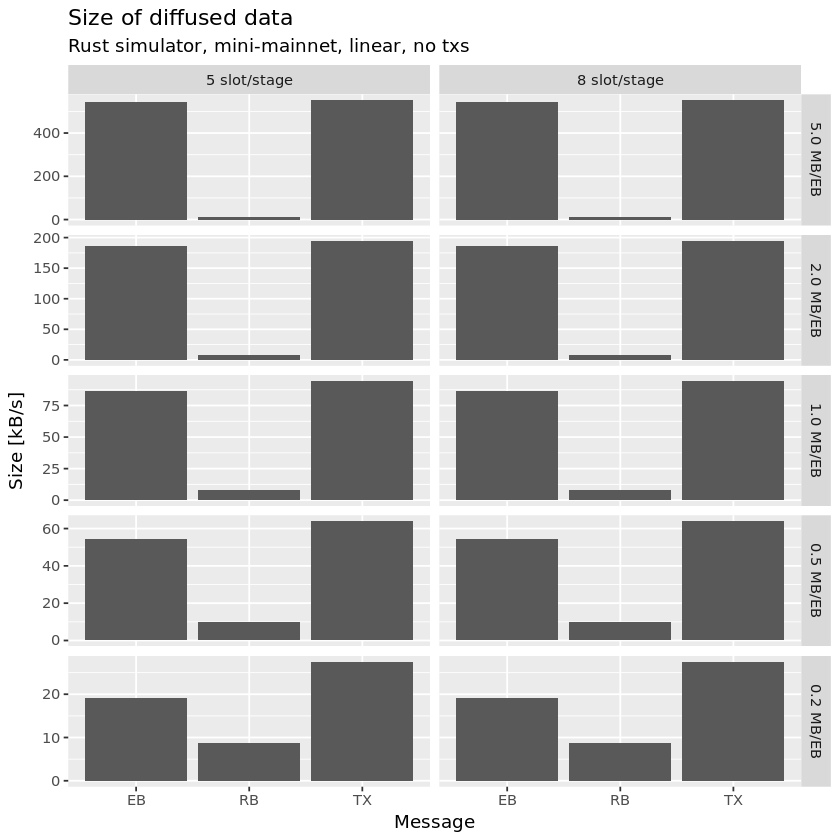

In [5]:
ggplot(
    lifecycle[,
        .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600),
        .(`Message`=`Kind`, `Stage length`, `Max EB size`)
    ],
    aes(x=`Message`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_grid(`Max EB size` ~ `Stage length`, scales="free_y") +
    ggtitle("Size of diffused data", subtitle=label)

In [6]:
ggsave("plots/notxs/sizes.png", units="in", dpi=150, width=8, height=6)

In [7]:
ggsave("plots/notxs/sizes.svg", units="in", dpi=150, width=8, height=6)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

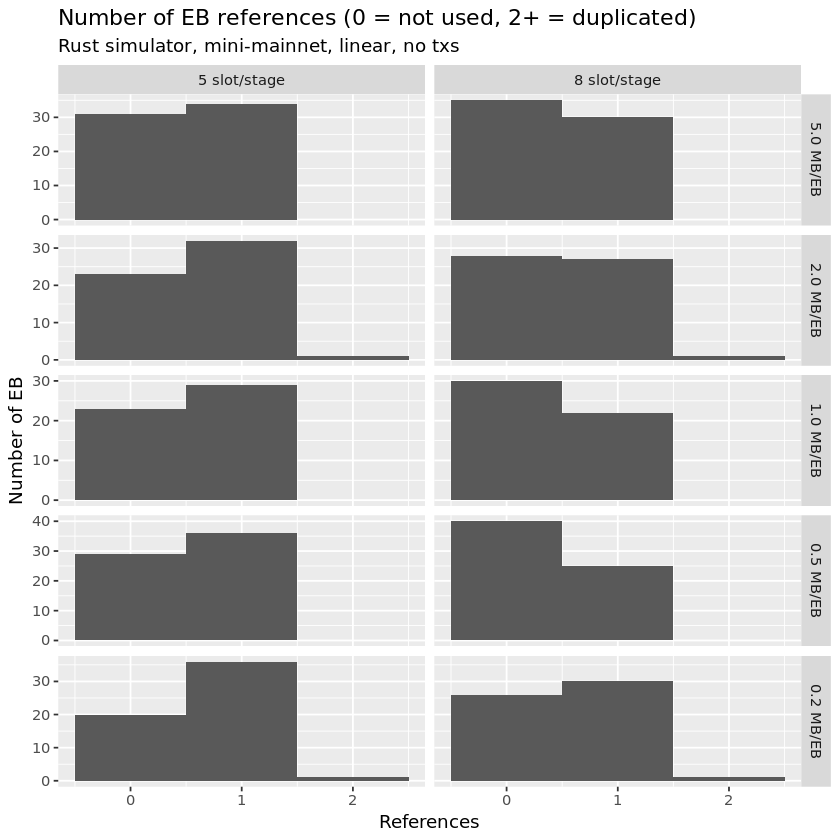

In [8]:
ggplot(
    lifecycle[
        `Kind` == "EB",
        .(`References`),
        .(`Stage length`, `Max EB size`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`Max EB size` ~ `Stage length`, scales="free_y") +
    ylab("Number of EB") +
    ggtitle("Number of EB references (0 = not used, 2+ = duplicated)", label)

In [9]:
ggsave("plots/notxs/references-tx.png", units="in", dpi=150, width=8, height=6)

In [10]:
ggsave("plots/notxs/references-tx.svg", units="in", dpi=150, width=8, height=6)

#### Release memory

In [11]:
rm(lifecycle)

In [12]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,937601,50.1,1892804,101.1,1892804,101.1
Vcells,1707442,13.1,8388608,64.0,2720200,20.8


### Resource usage

In [13]:
if (file.exists("results/notxs/resources.Rdata")) {
    load(file="results/notxs/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    resources <- fread("results/notxs/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(resources, file="results/notxs/resources.Rdata")
}
resources[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
resources %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator          Stage length     Max EB size         Node     
 Rust:7500   5 slot/stage :3750   5.0 MB/EB:1500   node-0  :  10  
             8 slot/stage :3750   2.0 MB/EB:1500   node-1  :  10  
             15 slot/stage:   0   1.0 MB/EB:1500   node-10 :  10  
                                  0.5 MB/EB:1500   node-100:  10  
                                  0.2 MB/EB:1500   node-101:  10  
                                                   node-102:  10  
                                                   (Other) :7440  
   Egress [B]          Disk [B]        Total CPU [s]    Maximum CPU [s/s]
 Min.   :       0   Min.   :       0   Min.   : 19.58   Min.   :0.3441   
 1st Qu.:  230441   1st Qu.:       0   1st Qu.: 32.26   1st Qu.:0.6079   
 Median : 5118412   Median :       0   Median : 39.30   Median :0.8143   
 Mean   : 6924111   Mean   :  149295   Mean   : 68.31   Mean   :1.3621   
 3rd Qu.:10394696   3rd Qu.:       0   3rd Qu.: 70.62   3rd Qu.:2.0273   
 Max.   :54784658   

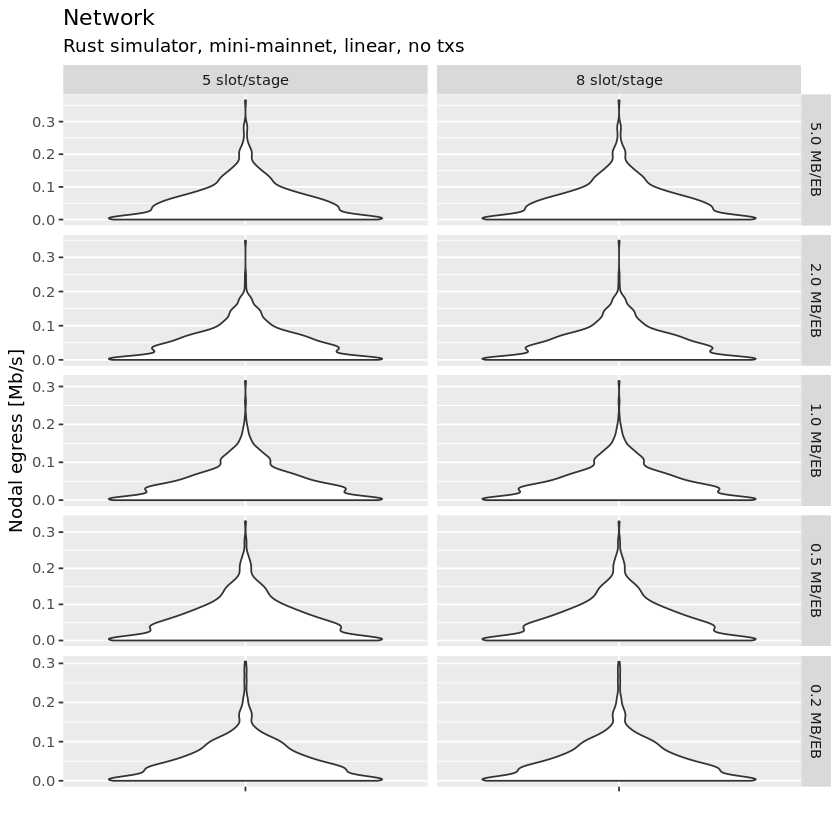

In [14]:
ggplot(
    resources[, .(`Stage length`, `Max EB size`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x="", y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    facet_grid(`Max EB size` ~ `Stage length`, scales="free_y") +
    xlab("") +
    ggtitle("Network", label)

In [15]:
ggsave("plots/notxs/network.png", units="in", dpi=150, width=9.5, height=5.5)

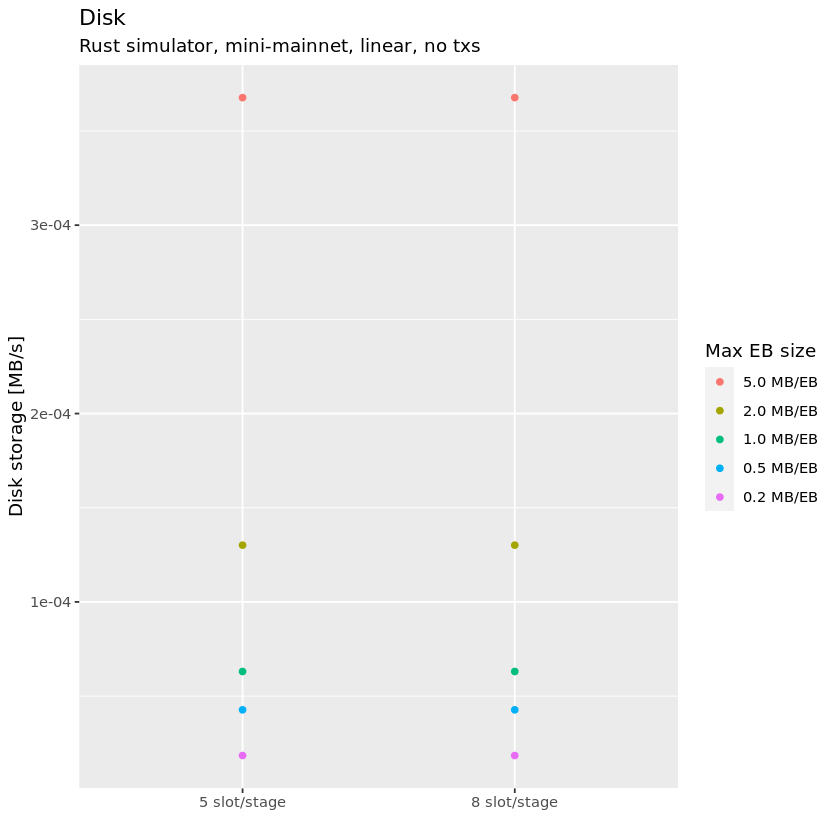

In [16]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/simFinish/1e6), .(`Stage length`, `Max EB size`)],
    aes(x=`Stage length`, color=`Max EB size`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    xlab("") +
    ggtitle("Disk", label)

In [17]:
ggsave("plots/notxs/disk.png", units="in", dpi=150, width=9.5, height=5.5)

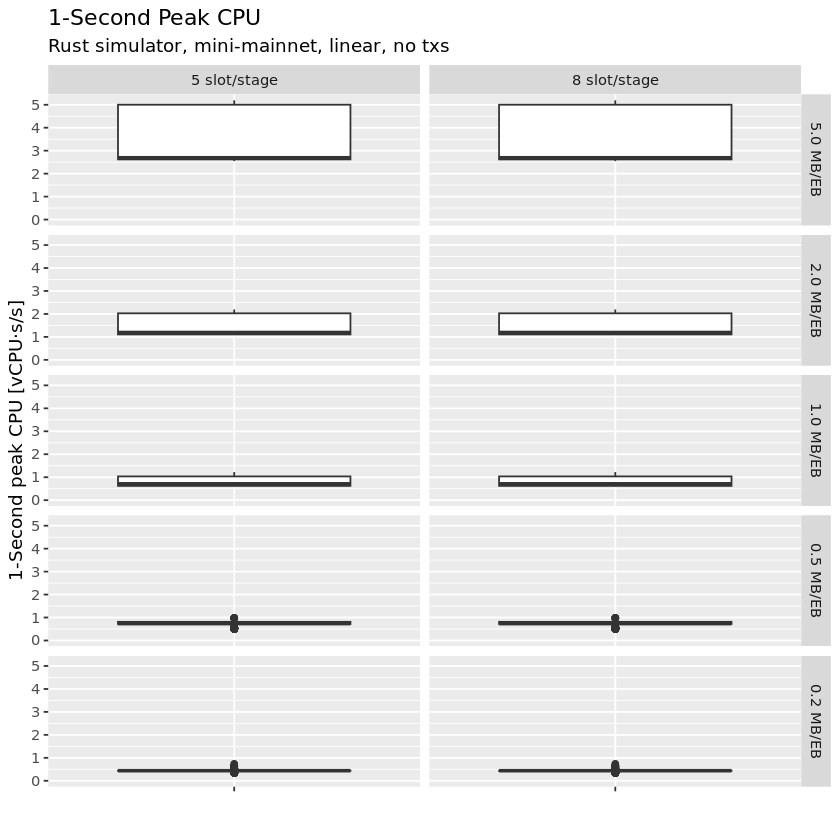

In [18]:
ggplot(
    resources[, .(`Node`, `Stage length`, `Max EB size`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x="", y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`Max EB size` ~ `Stage length`) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [19]:
ggsave("plots/notxs/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

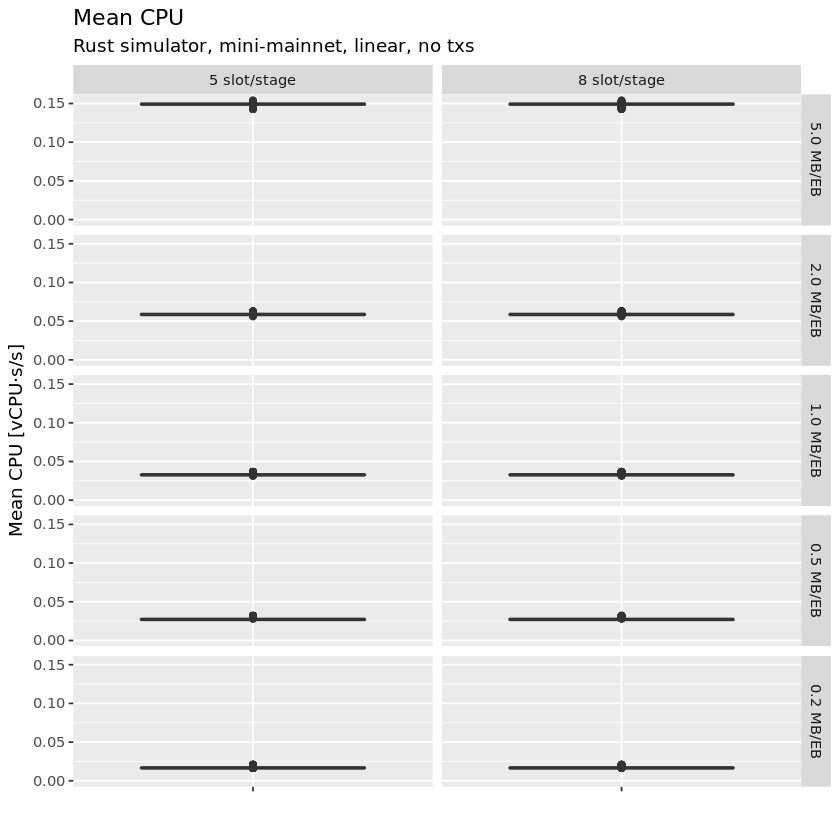

In [20]:
ggplot(
    resources[, .(`Stage length`, `Max EB size`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x="", y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`Max EB size` ~ `Stage length`) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [21]:
ggsave("plots/notxs/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [22]:
rm(resources)

In [23]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,988312,52.8,1892804,101.1,1892804,101.1
Vcells,1819669,13.9,8388608,64.0,5384398,41.1


### Receipt of messages

#### Read results

In [24]:
if (file.exists("results/notxs/receipts.Rdata")) {
    load("results/notxs/receipts.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    receipts <- fread("results/notxs/receipts.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(receipts, file="results/notxs/receipts.Rdata")
}
receipts[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
receipts %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator              Stage length         Max EB size       Kind         
 Rust:85098704   5 slot/stage :42549354   5.0 MB/EB:18618304   EB:  439778  
                 8 slot/stage :42549350   2.0 MB/EB:16335062   RB:  472824  
                 15 slot/stage:       0   1.0 MB/EB:15133798   VT:84186102  
                                          0.5 MB/EB:18643957                
                                          0.2 MB/EB:16367583                
                                                                            
                                                                            
           Item              Producer        Generated [s]    
 219-node-475:   18384   node-525:  450040   Min.   :  20.07  
 177-node-149:   18352   node-61 :  440960   1st Qu.: 298.84  
 65-node-61  :   18344   node-135:  439762   Median : 577.47  
 131-node-573:   18336   node-475:  439730   Mean   : 592.47  
 54-node-525 :   18296   node-529:  439502   3rd Qu.: 889.82  
 26-no

In [25]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB RB VT
Levels: EB RB VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [26]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`Stage length`, `Max EB size`, `Elapsed [s]`, `Minute created`=factor(floor(`Generated [s]`/60)))],
        aes(x=`Elapsed [s]`, fill=`Minute created`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`Max EB size` ~ `Stage length`, scales=scales) +
#       coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

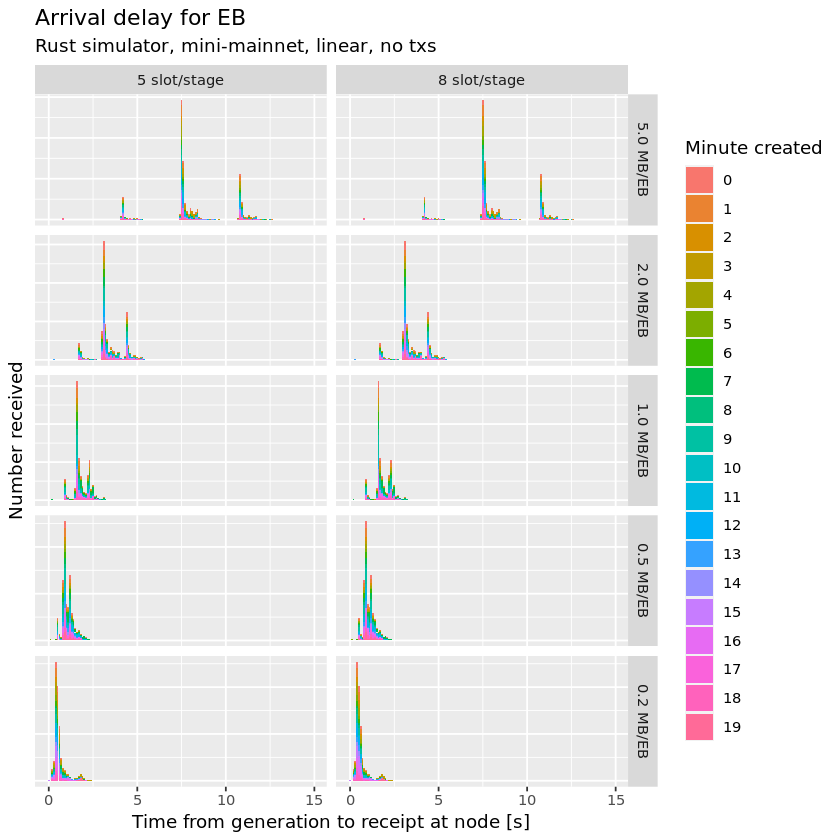

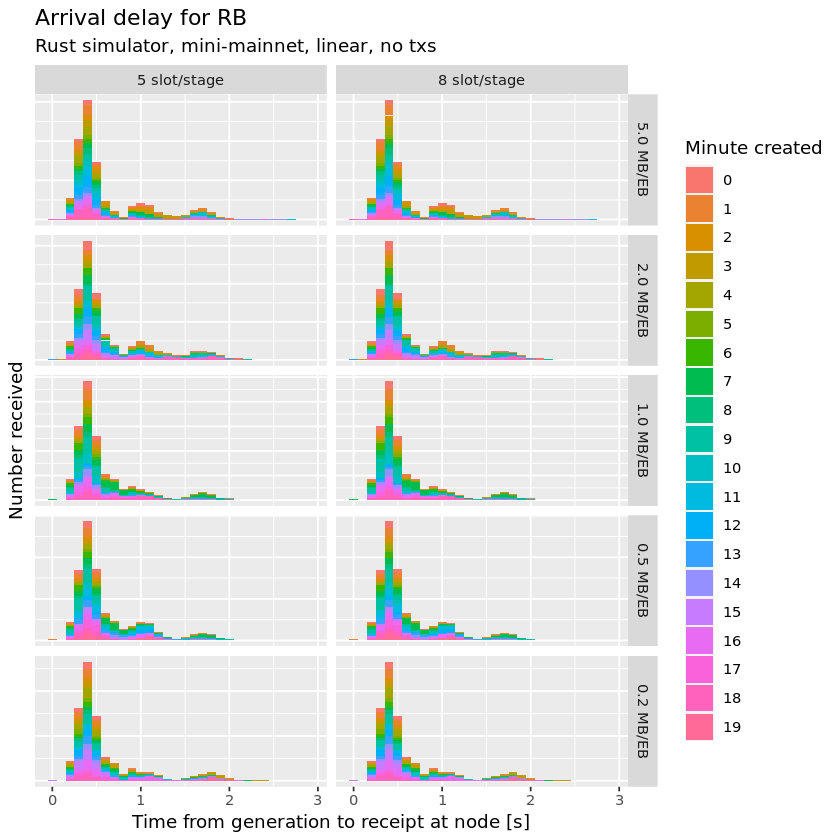

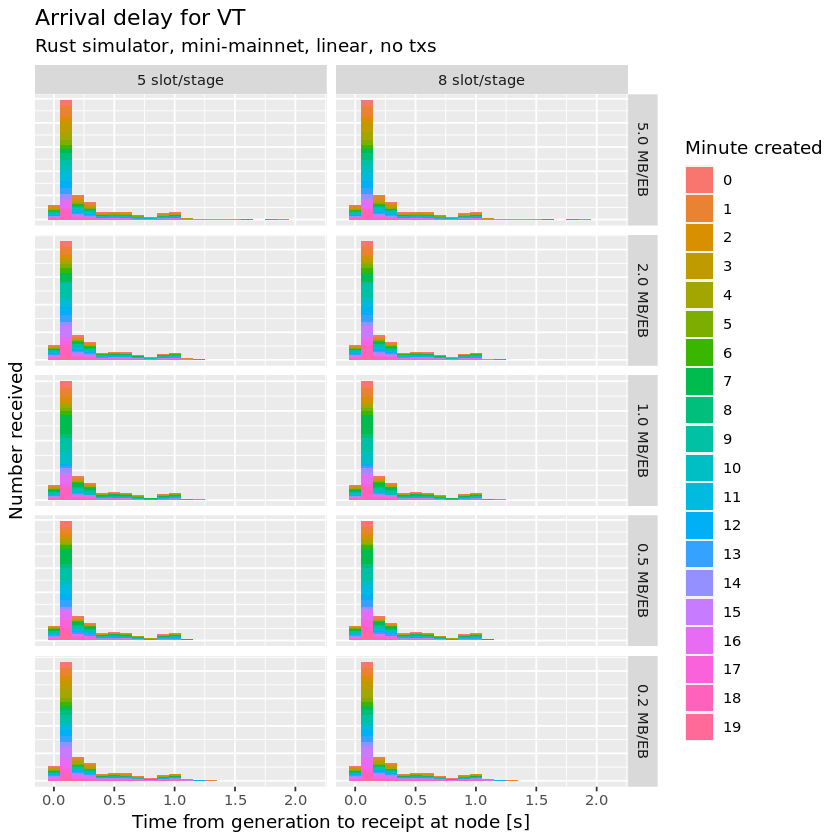

In [27]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/notxs/elapsed-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [28]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9/sampleSize),
            by=.(`Stage length`, `Max EB size`, `Slot`=floor(`Received [s]`), `Message`=`Kind`)
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Max EB size` ~ `Stage length`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

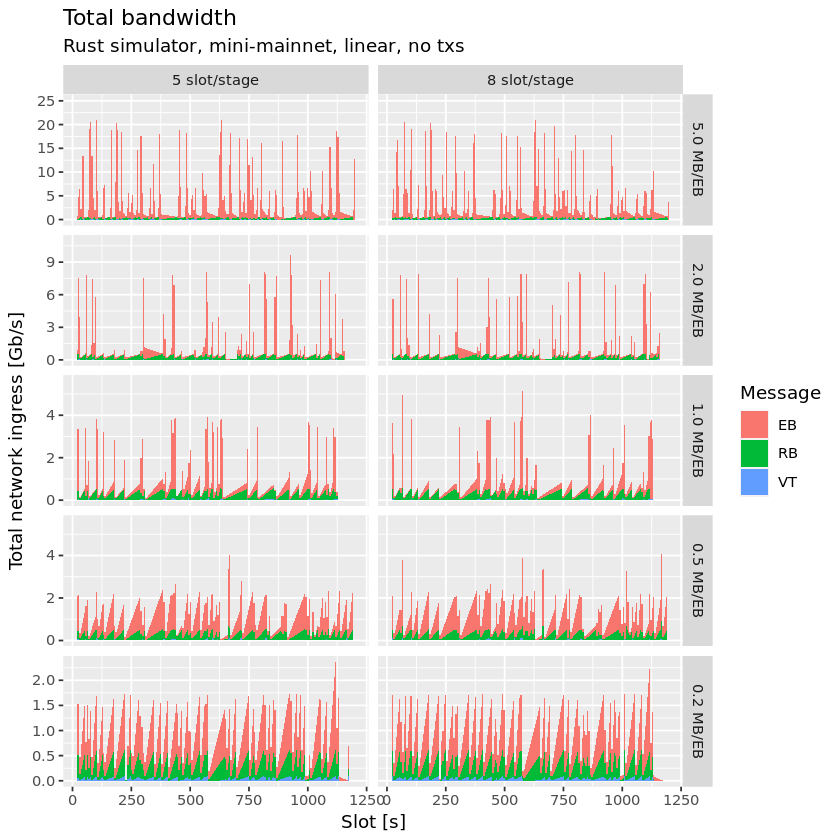

In [29]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    scales="free_y",
    outfiles=paste0("plots/notxs/ingress-total-area.png")
)

##### Bandwidth usage per node

In [30]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [31]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Mb/node]`=8*sum(`Size [B]`)/1e6 /nodeCount/sampleSize),
            by=.(`Stage length`, `Max EB size`, `Slot`=floor(`Received [s]`), `Message`=`Kind`)
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Max EB size` ~ `Stage length`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

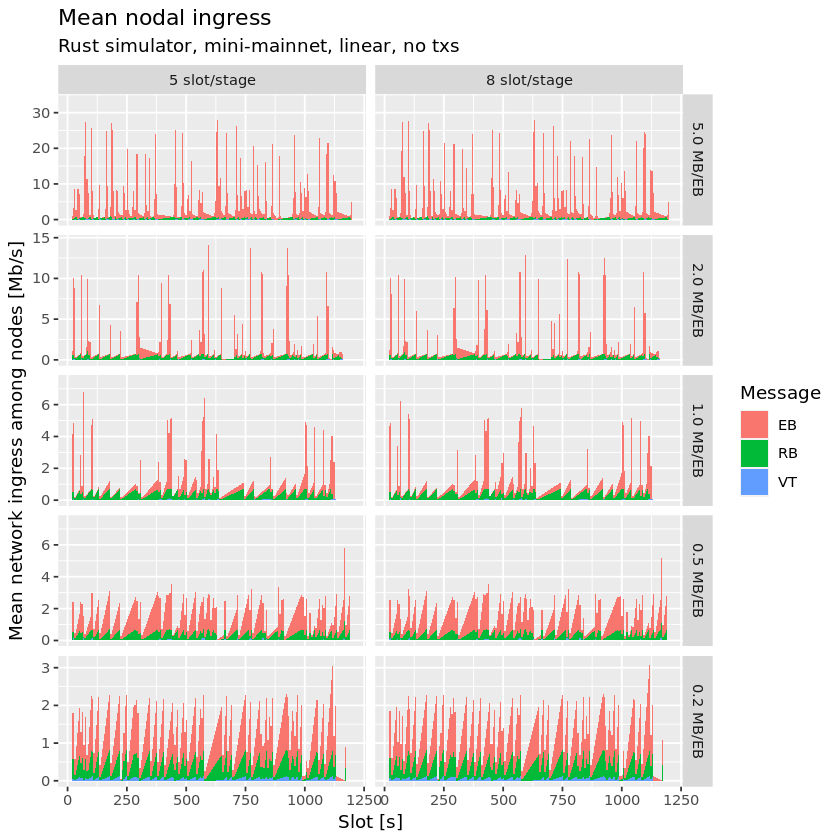

In [32]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    scales="free_y",
    outfiles=paste0("plots/notxs/ingress-average-area.png")
)

In [33]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6/sampleSize),
            by=.(`Stage length`, `Max EB size`, `Slot`=floor(`Received [s]`), `Message`=`Kind`, `Recipient`)
        ][,
            .(`Size [Mb]`=max(`Size [Mb]`)),
            by=.(`Stage length`, `Max EB size`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Max EB size` ~ `Stage length`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

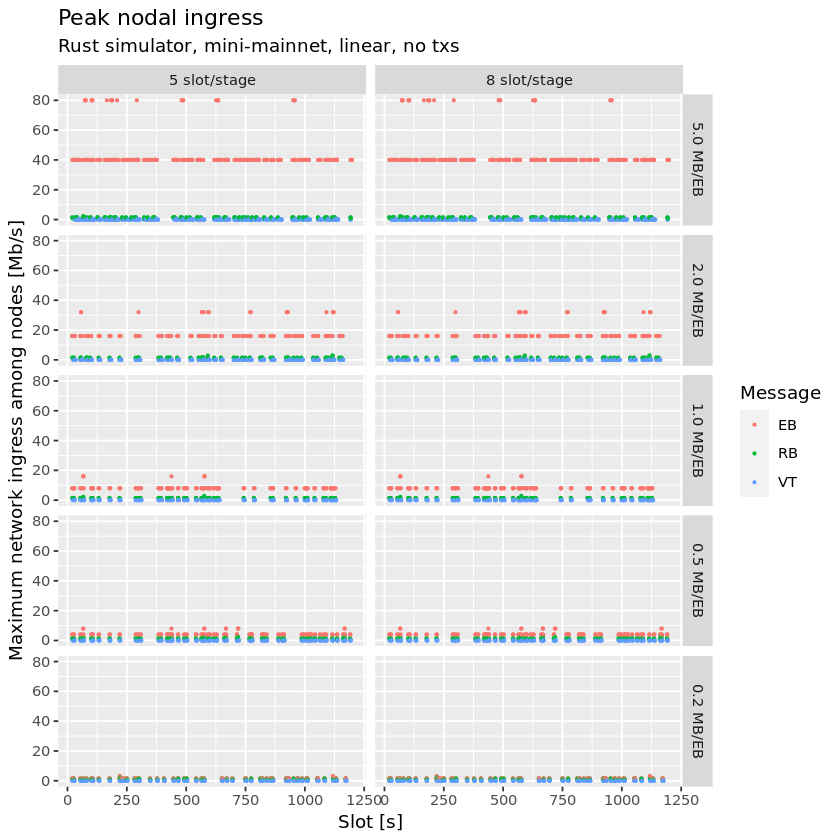

In [34]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/notxs/ingress-peak-point.png")
)

#### Release memory

In [35]:
rm(receipts)

In [36]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1039222,55.6,2311364,123.5,2311364,123.5
Vcells,640276704,4885.0,1715222804,13086.2,2680035630,20447.1


### CPU usage

#### Read results

In [37]:
if (file.exists("results/notxs/cpus.Rdata")) {
    load(file="results/notxs/cpus.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    cpus <- fread("results/notxs/cpus.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(cpus, file="results/notxs/cpus.Rdata")
}
cpus[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
cpus %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator              Stage length         Max EB size            Slot       
 Rust:85653318   5 slot/stage :42826661   5.0 MB/EB:18740522   Min.   :  20.0  
                 8 slot/stage :42826657   2.0 MB/EB:16440750   1st Qu.: 299.0  
                 15 slot/stage:       0   1.0 MB/EB:15231892   Median : 577.0  
                                          0.5 MB/EB:18765611   Mean   : 592.2  
                                          0.2 MB/EB:16474543   3rd Qu.: 889.0  
                                                               Max.   :1199.0  
                                                                               
       Node               Task           Duration [s]     
 node-409:  114734   GenRB  :    1180   Min.   :0.000164  
 node-470:  114734   GenVote:  112724   1st Qu.:0.000816  
 node-466:  114730   ValEB  :  439778   Median :0.000816  
 node-697:  114730   ValRB  :  472824   Mean   :0.005981  
 node-491:  114726   ValRH  :  440710   3rd Qu.:0.000816  
 node-

In [38]:
cpusNode <-
cpus[
    ,
    .(`Duration [s]`=sum(`Duration [s]`)),
    by=.(`Stage length`, `Max EB size`, `Node`, `Slot`)
]

In [39]:
nodeCount <- cpusNode[, length(unique(`Node`))]
nodeCount

[1] 750

#### Peak CPU usage

##### Histogram

In [40]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*max(`Duration [s]`)),
            by=.(`Stage length`, `Max EB size`, `Slot`)
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`Max EB size` ~ `Stage length`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

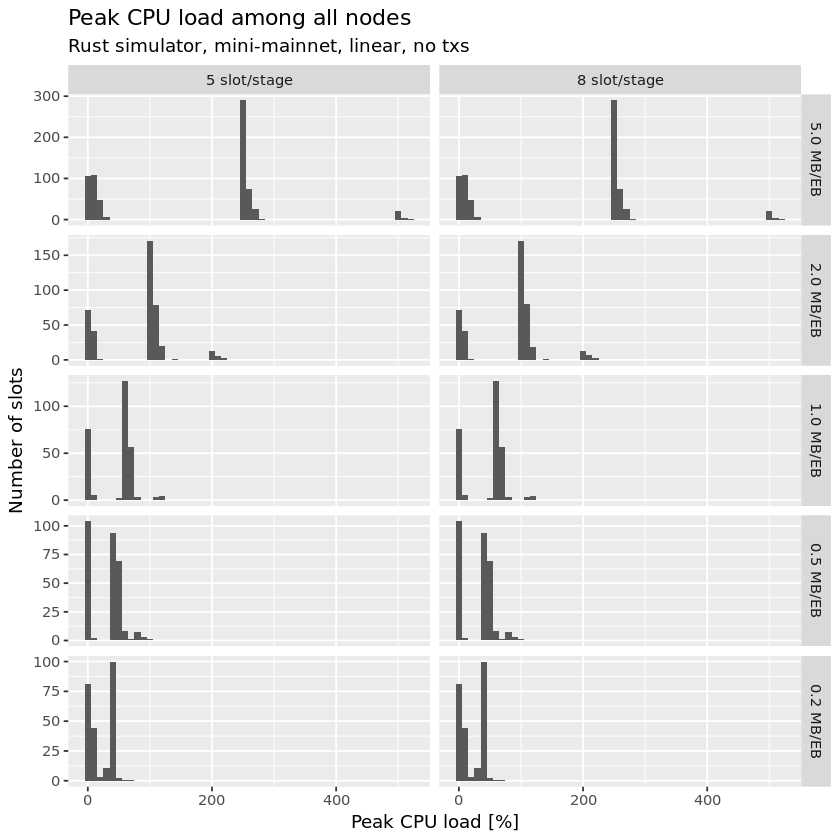

In [41]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/notxs/cpu-peak-histogram.png")
)

##### Time series

In [42]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*mean(`Duration [s]`)/sampleSize),
            by=.(`Stage length`, `Max EB size`, `Slot`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`Max EB size` ~ `Stage length`, scale=scales) +
#       scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

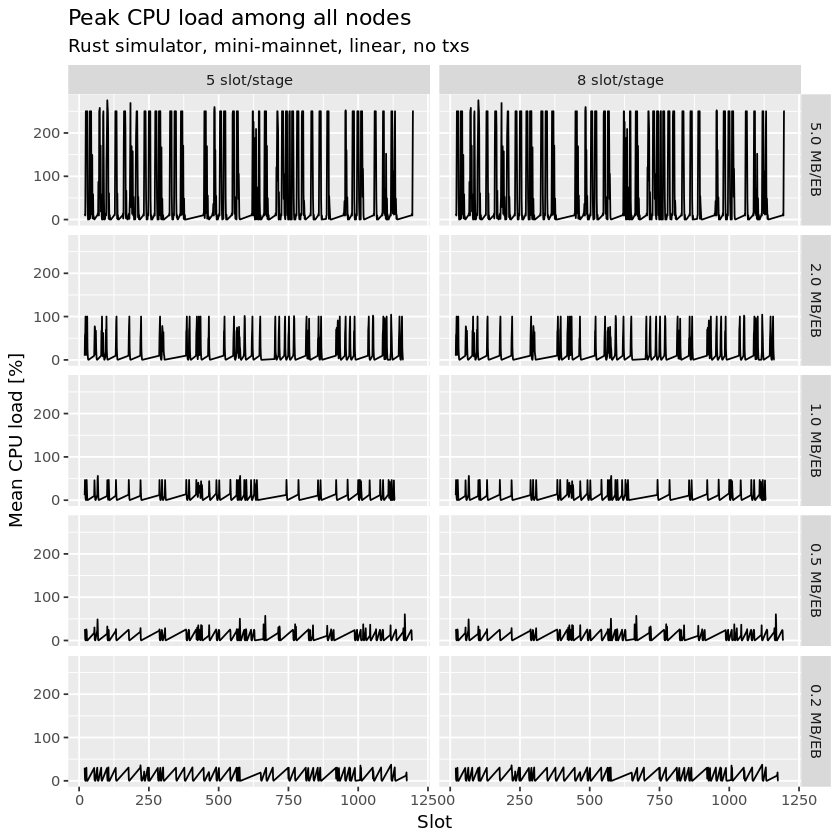

In [43]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/notxs/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [44]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Stage length`, `Max EB size`, `Task`)
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`Max EB size` ~ `Stage length`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

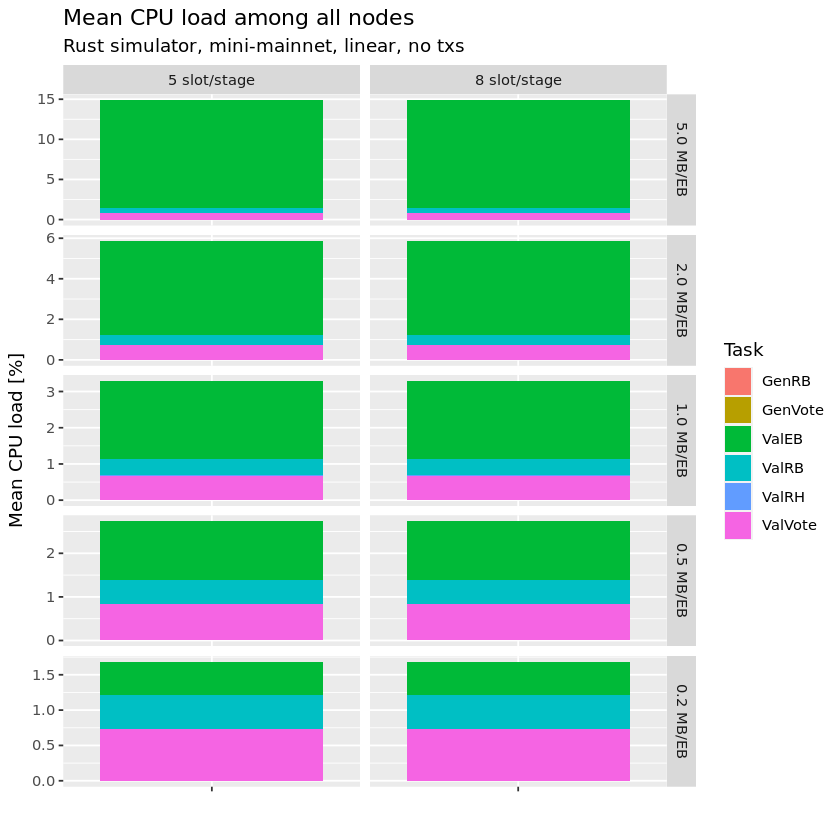

In [45]:
meanCpuHistogram(
    cpus,
    nodeCount * simFinish * sampleSize, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/notxs/cpu-mean-histogram.png")
)

##### Time series

In [46]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Stage length`, `Max EB size`, `Slot`, `Task`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`Max EB size` ~ `Stage length`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

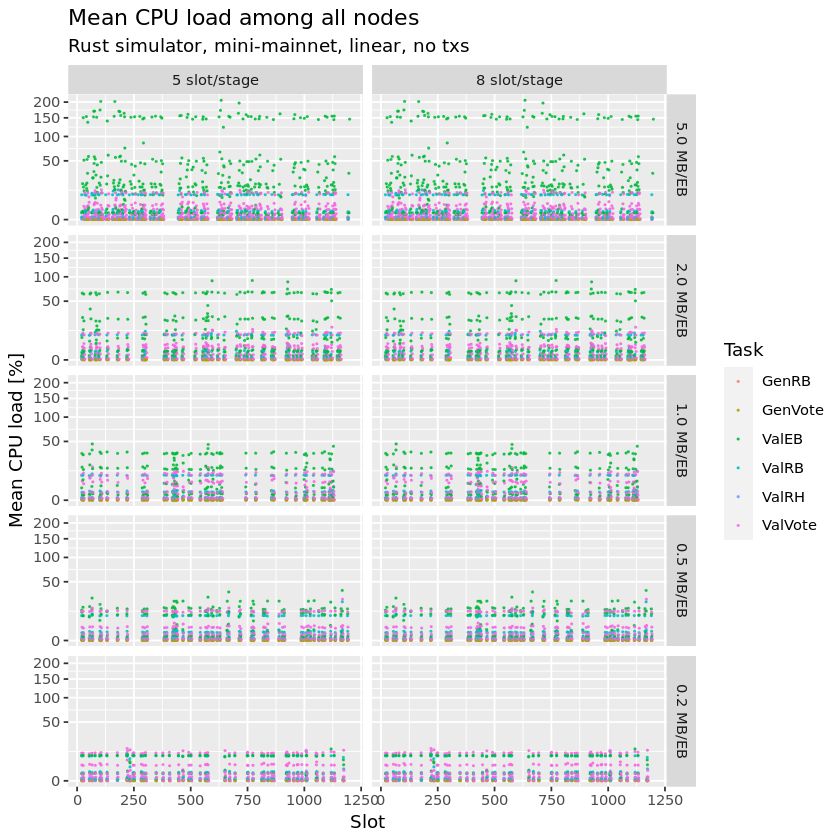

In [47]:
meanCpuTimeseries(
    cpus, 
    nodeCount * sampleSize, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/notxs/cpu-mean-timeseries.png")
)

#### Release memory

In [48]:
rm(cpus, cpusNode)

In [49]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1007633,53.9,2311364,123.5,2311364,123.5
Vcells,344556760,2628.8,1372178244,10468.9,2680035630,20447.1
